In [24]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
# Parametros de los archivos

categoria =  'CarnicosData'
vista = categoria + "-Ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df2 = xl.parse('dt1')
df0 = pd.DataFrame(df2)


dir_actual = os.getcwd()

Pais = "Carnico"

path = os.path.join(dir_actual, Pais)

try:
  os.mkdir(path)
except:
  print("An exception occurred") 




['FEM VOLUMEN ', 'FEM VALOR', 'dt1pe', 'dt2pe', 'dt1pe (2)', 'dt3pe', 'dt1ar', 'dt2ar', 'dt3ar', 'dt1cl', 'dt2cl', 'dt1cl (3)', 'dt1bo', 'dt2bo', 'dt3bo', 'dt4bo']
An exception occurred


TOTAL FEMCARE
MAPE TOTAL FEMCARE = 3.1972767934871333
PROTECTORES
MAPE PROTECTORES = 7.995447023474689
Nocturnas
MAPE Nocturnas = 6.451388113924115
Normales
MAPE Normales = 3.7611202823559537
Ultradelgadas
MAPE Ultradelgadas = 111.54365318010349


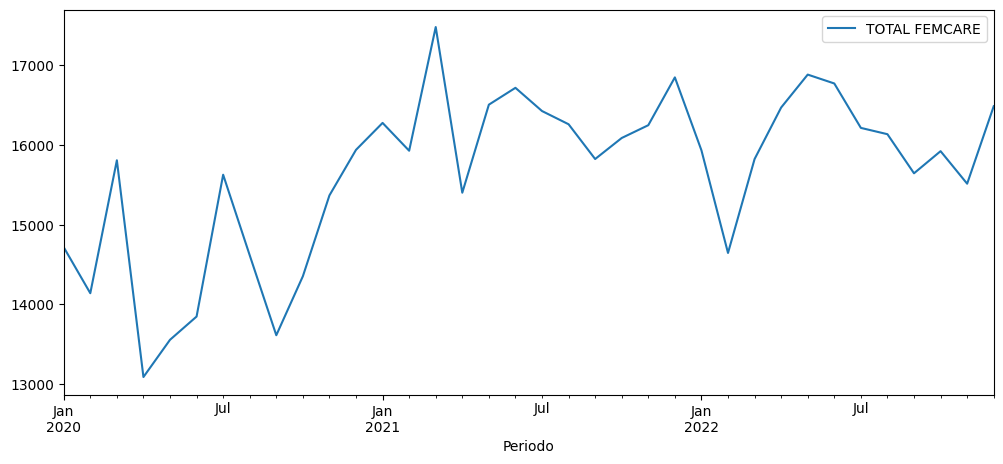

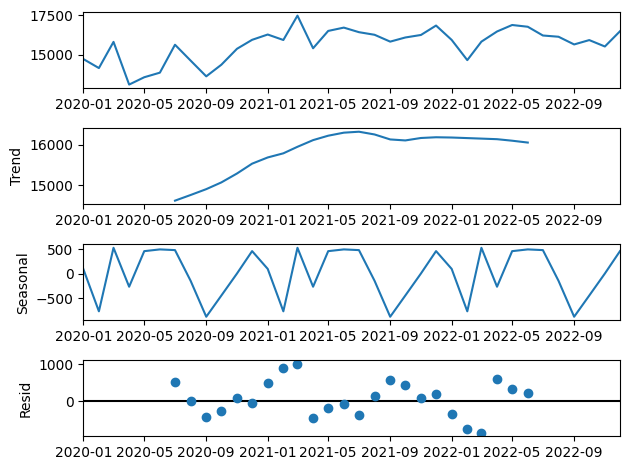

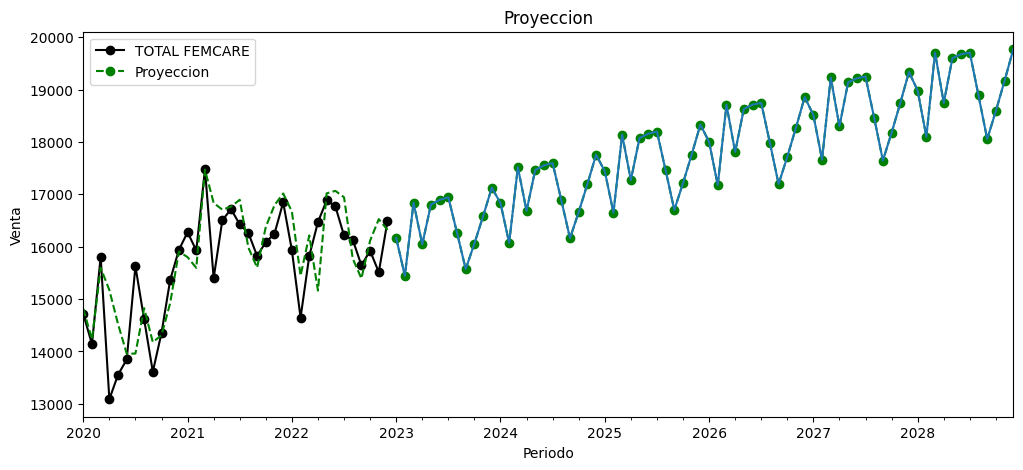

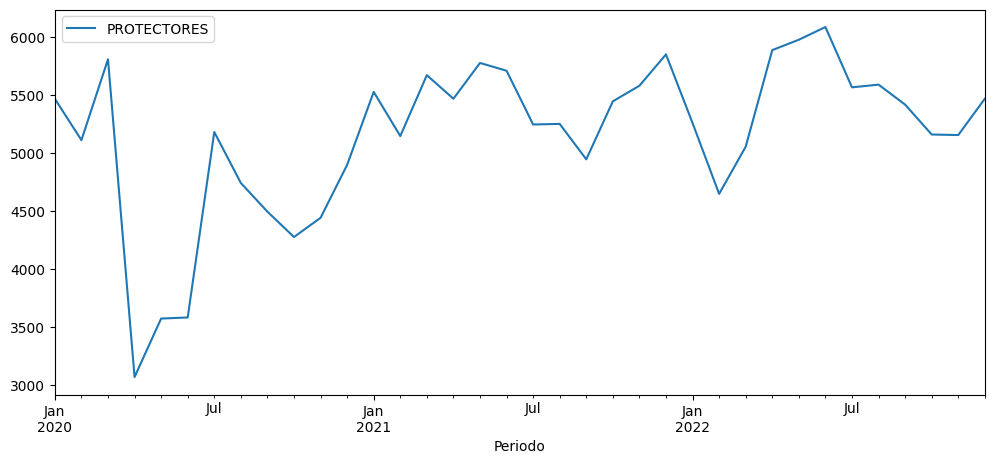

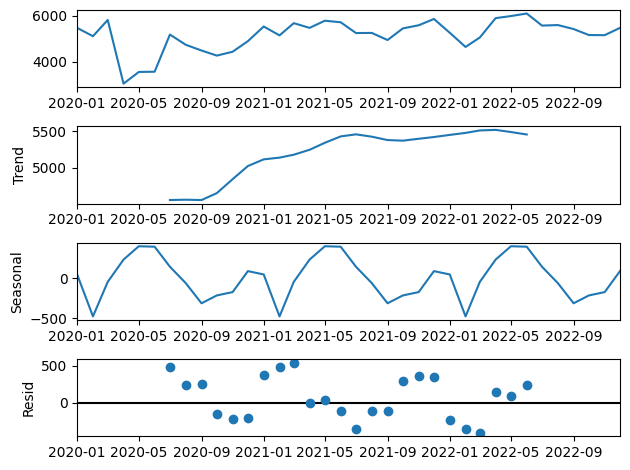

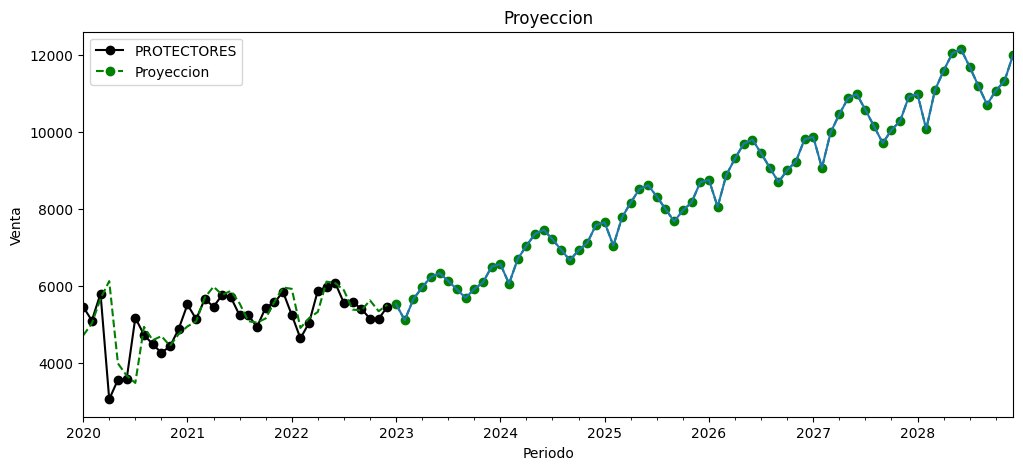

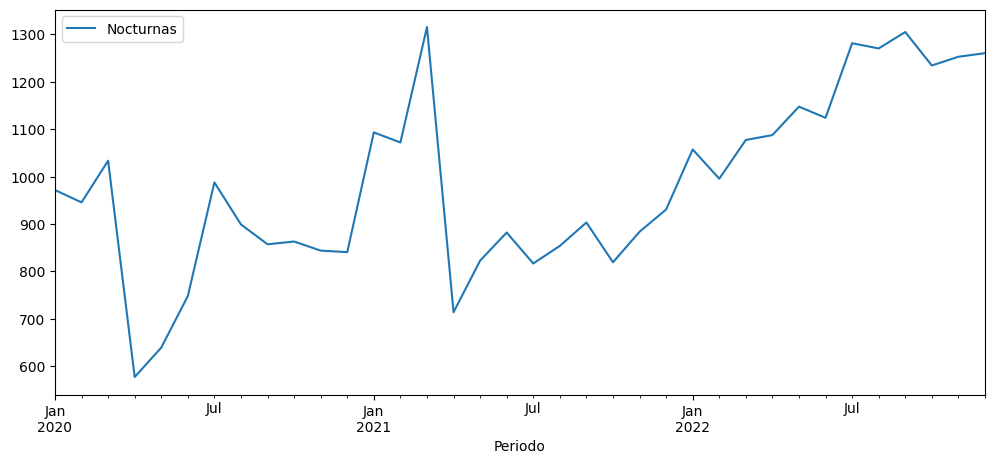

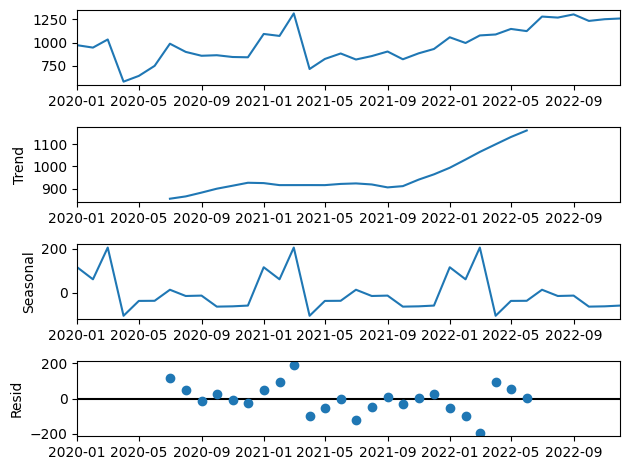

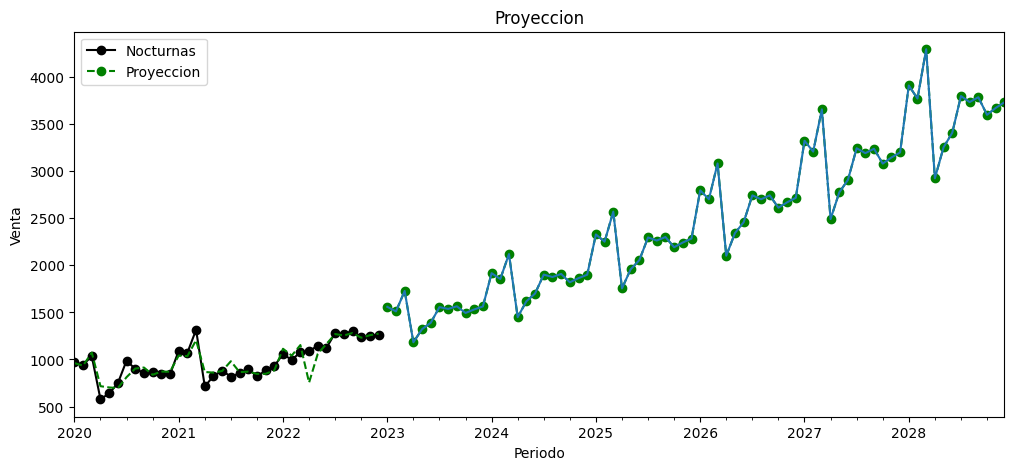

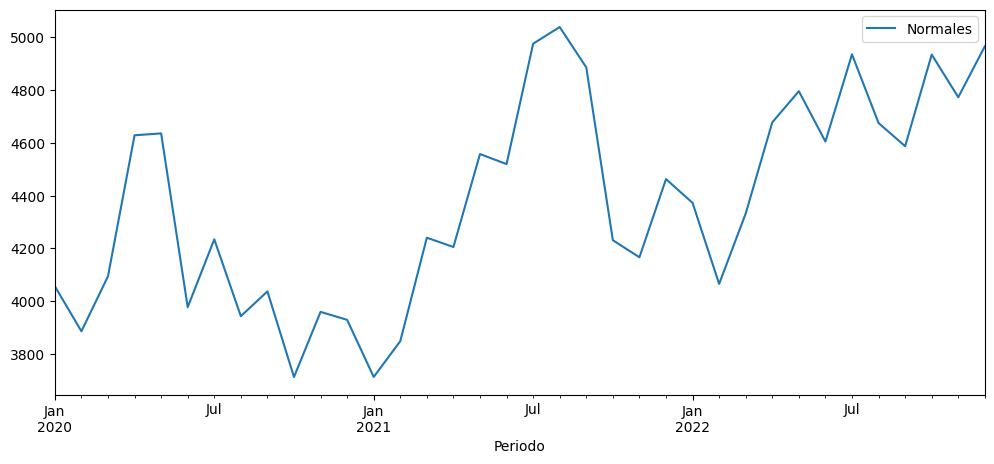

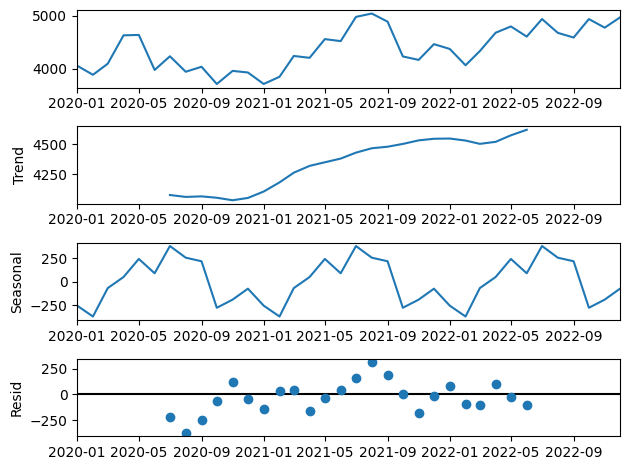

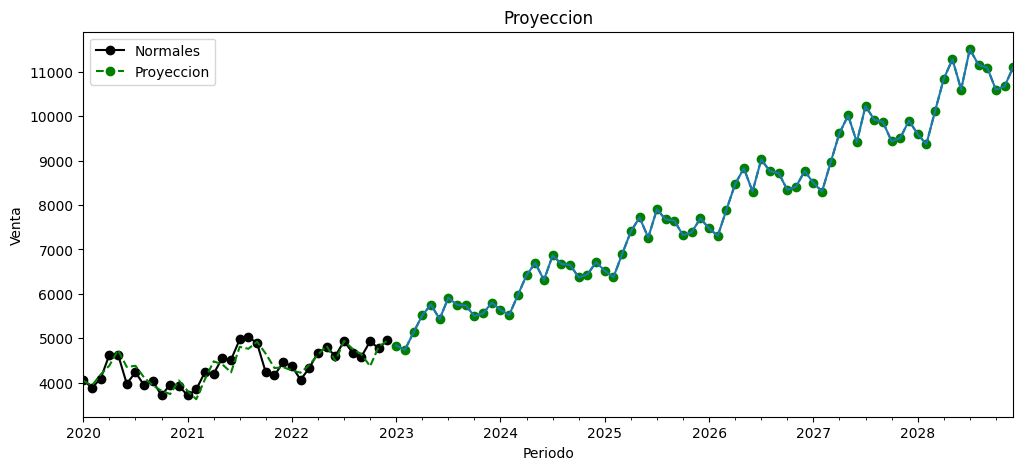

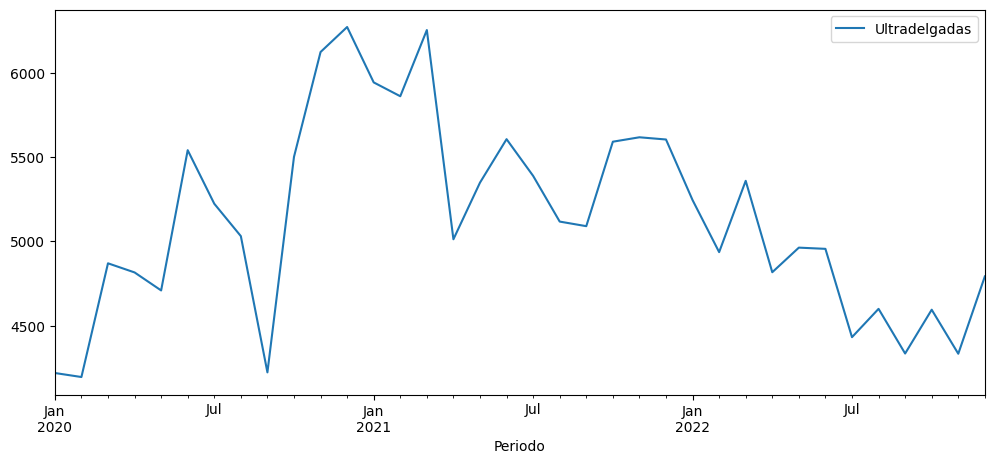

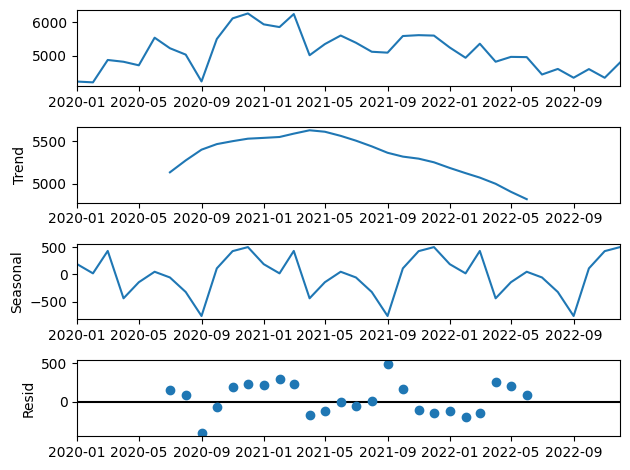

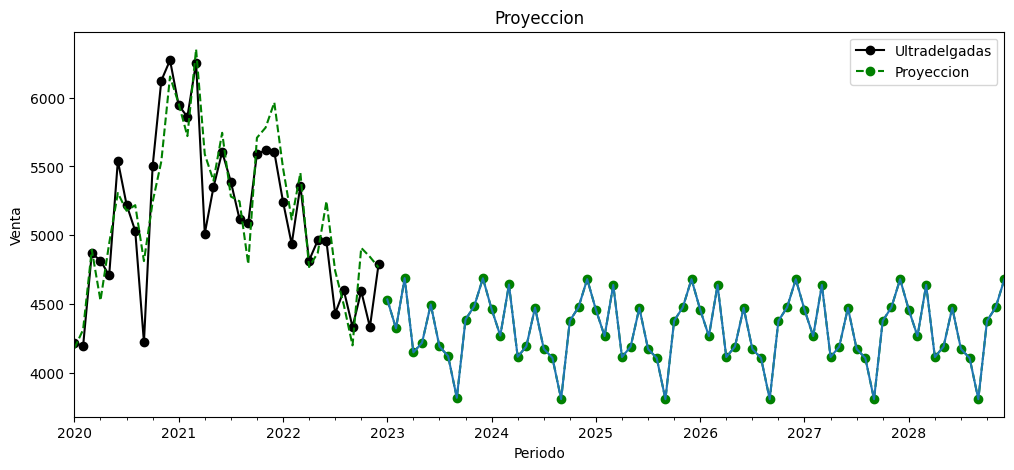

In [26]:
# Crea la proyeccion

df3 = df2

# Determina las columnas y hace la proyeccion 
for (columnName, columnData) in df3.items():
    #print('Column Name : ', columnName)
    #print('Column Contents : ', columnData.values)
    # Parametros personalizados
    ptrend = 'mul'
    pseasonal = 'mul'
    pdamped = True
    puse = True
    periodos = 12

    if (columnName != 'Periodo') :
        print(columnName)
        df10 = df3[df3[columnName] > 0]
        df10 = df10[['Periodo', columnName]]
        df10 = df10.set_index('Periodo')
        df10.plot(figsize=(12, 5))
        # Analisis de descomposicion        
        components = seasonal_decompose(df10, period=8)
        components.plot()
        # Proyeccion
        fit1 = ExponentialSmoothing(df10, seasonal_periods=periodos,trend=ptrend,seasonal=pseasonal,damped_trend=pdamped,use_boxcox=puse,initialization_method="estimated").fit()
        #print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]    
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 = columnName + "_minimo"
        col1 = columnName + "_maximo"
        
        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        
        # Salva los intervalos
        mdir = os.path.join(dir_actual, Pais)
        mfila = vista + '-py_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        ax.set_ylabel("Venta")
        ax.set_xlabel("Periodo") 
        fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )

        
        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]
        
        df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"
        
        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE
        df99 = [df7]        
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10[[columnName]])    
        print("MAPE " + columnName + " = " + str(mape(xx,yy)))

        


# Une la salida
df=[] 
mdir = os.path.join(dir_actual, Pais)
mfila = os.path.join(mdir, vista + "-py*")
files = glob.glob(mfila)
for a in files:

    df.append( pd.read_excel(a, sheet_name='Sheet1'))   

i = 0
for x in df:     
    if i > 0 :
        dt = pd.merge(dt, df[i])
    else :
        dt = df[0]
    i = i + 1
    
# Salva la proyeccion final de cada serie
mdir = os.path.join(dir_actual, Pais)
mfila = vista + '-final.xlsx'
dirPath = os.path.join(mdir, mfila)
dt.to_excel(dirPath)


In [27]:
# Salva las proyecciones agrupadas
mdir = os.path.join(dir_actual, Pais)
mfila = vista + '-final.xlsx'
dirPath = os.path.join(mdir, mfila)

orden = df0.columns.values


df1 = pd.ExcelFile(dirPath)
df2 = df1.parse("Sheet1")

df2['Periodo']= pd.to_datetime(df2['Periodo'])

df3 = df2[df2['Periodo'] > fecha_inicio ]

df3 = df3[df3.columns.drop(list(df3.filter(regex='_ajuste')))]

df3.columns = df3.columns.str.replace("_proyeccion", "")


df3 = df3[orden]


df3 = pd.DataFrame(np.concatenate([df0,df3],  axis = 0 ),columns=df0.columns)

mdir = os.path.join(dir_actual, Pais)
mfila = vista + '-Crecimientos.xlsx'
dirPath = os.path.join(mdir, mfila)
df3.to_excel(dirPath, index=False)


df4 = (df3.groupby(df3.Periodo.dt.year).sum())
# Salva la totalizacion de la proyeccion
mdir = os.path.join(dir_actual, Pais)
mfila = vista + '-Totales.xlsx'
dirPath = os.path.join(mdir, mfila)
df4.to_excel(dirPath, index_label="Periodo")
print("Termino")



Termino


In [28]:
mdir = os.path.join(dir_actual, Pais)

dft4 = pd.DataFrame()

orden = df0.columns.values
orden = orden[1:]
for el in orden:
    
    mfila = vista + "-py_"+el+".xlsx"
    proy = os.path.join(mdir, mfila)
    mfila = vista + "-py_intervalo_"+el+".xlsx"
    int = os.path.join(mdir, mfila)
    
    df1 = pd.read_excel(proy)
    df2 = pd.read_excel(int)

    df2['Periodo'] = pd.to_datetime(df2['Periodo'])
    df1['Periodo'] = pd.to_datetime(df1['Periodo'])
    df1=df1.drop(columns=[el + "_ajuste"])
    df3 = pd.merge(df1, df2, on="Periodo")


    df4 = (df3.groupby(df3.Periodo.dt.year).sum())
    df5 = df0[['Periodo', el]]
    df6 = (df5.groupby(df5.Periodo.dt.year).sum())
    df7 = pd.concat([df6,df4],axis=0)
    # Salva los intervalos de las proyecciones agrupadas
    mfila = vista+ "-"+ el +"-total-intervalos.xlsx"
    dirPath = os.path.join(mdir, mfila)
    df7.to_excel(dirPath)
    
    if i == 0:
        print(el)
        dft4 =df7
    else:
        dft4 = pd.concat([dft4,df7],axis=1)    
    
    print("Termino " + el)

dirPath = os.path.join(mdir, vista + "-Total-Intervalos.xlsx")
dft4.to_excel(dirPath)    


Termino TOTAL FEMCARE
Termino PROTECTORES
Termino Nocturnas
Termino Normales
Termino Ultradelgadas


In [29]:
# Crecimientos

df99 = pd.read_excel(dirPath)
df99 = df99.fillna(0)

orden = df0.columns.values
orden = orden[1:]
for el in orden:

    promedio = el + "_proyeccion"
    minimo = el + "_minimo" 
    maximo = el + "_maximo" 

    esc1 = el + "_prom"
    esc2 = el + "_min"
    esc3 = el + "_max"
    # Suma los escenarios
    df99[esc1] = df99[el] + df99[promedio]
    df99[esc2] = df99[el] + df99[minimo]
    df99[esc3] = df99[el] + df99[maximo]

    # borra las columnas que ya no se necesitan
    del df99[el]
    del df99[promedio]
    del df99[minimo]
    del df99[maximo]

    dirPath1 = os.path.join(mdir, vista + "-Total-Intervalos_Anuales.xlsx")
    df99.to_excel(dirPath1,index=False)  

print("Termino")



Termino
